# SOOR

# Installations and Imports

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
from numpy import linalg

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear
from torch_geometric.utils import to_networkx, from_networkx

import random

import networkx as nx

from scipy import stats

import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}')

seeds = [42, 220, 123, 456, 789, 1011, 1699, 38994, 52139, 123456]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Running on cuda


# Models

In [ ]:
# Node classification model
class GCNNode(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNode, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training Utils

## Node Classification Training

In [ ]:
def train_evaluate_node(input_dim, hidden_dims, output_dim, data, seeds, lr=1e-2, weight_decay=5e-4, patience=10):
    accuracies = []

    for seed in seeds:
        print(f"\nSeed: {seed}")
        set_seed(seed)

        model = GCNNode(input_dim, hidden_dims, output_dim).to(device)
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(300):
            model.train()
            optimizer.zero_grad()

            data = data.to(device)
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch}")
                break

            if (epoch + 1) % 10 == 0:
                print(f"  Epoch: {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        model.eval()
        data = data.to(device)
        _, pred = model(data.x, data.edge_index).max(dim=1)
        correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / int(data.test_mask.sum())

        accuracies.append(acc)
        print(f"  Test Accuracy: {acc:.4f}")

    avg_accuracy = np.mean(accuracies)
    variance_accuracy = np.var(accuracies)

    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    print(f"Variance of Accuracy: {variance_accuracy:.4f}")

    return accuracies

# Rewiring Algorithm

The basic idea is to use the curvature inequality in "Revisiting Over-smoothing and Over-squashing Using Ollivier-Ricci Curvature" without actually calculating the curvature.
$$\frac{|\mathcal{N}_u \cap \mathcal{N}_v|}{\max(m, n)} \geq \kappa(u, v)$$

In [ ]:
def remove_edges_with_spectral_smoothing(data, num_edges_to_remove, k=1):
    G = to_networkx(data, to_undirected=True)
    num_edges_before = G.number_of_edges()

    # Compute the Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()

    # Compute the eigenvalues and eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = linalg.eigh(L)

    # Sort the eigenvalues and eigenvectors in ascending order
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the eigenvectors corresponding to the k smallest eigenvalues
    smoothest_eigenvectors = eigenvectors[:, 1:k+1]  # Exclude the first eigenvector

    # Compute the contribution of each edge to the smoothest eigenvectors
    edge_scores = {}
    for u, v in G.edges():
        edge_scores[(u, v)] = np.sum((smoothest_eigenvectors[u] - smoothest_eigenvectors[v])**2)

    # Sort the edges based on their scores in ascending order
    sorted_edges = sorted(edge_scores.items(), key=lambda x: x[1])

    # Remove the edges with the lowest scores
    edges_to_remove = [edge for edge, score in sorted_edges[:num_edges_to_remove]]
    G.remove_edges_from(edges_to_remove)

    num_edges_after = G.number_of_edges()
    rewired_data = from_networkx(G)

    # Clone the original data object
    data_rewired = data.clone()
    data_rewired.edge_index = rewired_data.edge_index

    print(f"Number of edges removed: {num_edges_before - num_edges_after}")
    return data_rewired

# Results

## Cora

Processing...
Done!



Seed: 42
  Epoch: 10, Train Loss: 0.8669, Val Loss: 1.3184
  Epoch: 20, Train Loss: 0.2777, Val Loss: 0.9297
  Epoch: 30, Train Loss: 0.1487, Val Loss: 0.9010
  Epoch: 40, Train Loss: 0.0665, Val Loss: 0.9167
  Early stopping at epoch 45
  Test Accuracy: 0.7870

Seed: 220
  Epoch: 10, Train Loss: 0.8839, Val Loss: 1.2944
  Epoch: 20, Train Loss: 0.2839, Val Loss: 0.9618
  Epoch: 30, Train Loss: 0.0817, Val Loss: 0.9310
  Epoch: 40, Train Loss: 0.0570, Val Loss: 0.8791
  Early stopping at epoch 45
  Test Accuracy: 0.8120

Seed: 123
  Epoch: 10, Train Loss: 0.7564, Val Loss: 1.2368
  Epoch: 20, Train Loss: 0.2484, Val Loss: 0.9405
  Epoch: 30, Train Loss: 0.1003, Val Loss: 0.9429
  Epoch: 40, Train Loss: 0.0591, Val Loss: 0.9113
  Epoch: 50, Train Loss: 0.0585, Val Loss: 0.9592
  Early stopping at epoch 52
  Test Accuracy: 0.8000

Seed: 456
  Epoch: 10, Train Loss: 0.8678, Val Loss: 1.3642
  Epoch: 20, Train Loss: 0.2829, Val Loss: 0.9399
  Epoch: 30, Train Loss: 0.1246, Val Loss: 0.966

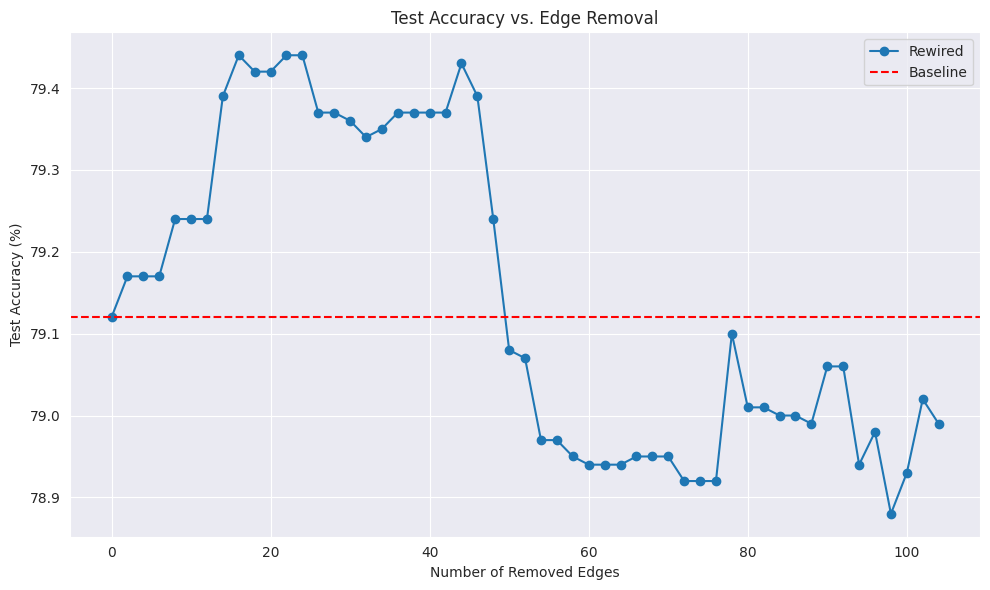

In [ ]:

patience = 10

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
num_edges_before = G.number_of_edges()

# Get the model dimensions
input_dim = dataset.num_node_features
hidden_dims = 16
output_dim = dataset.num_classes

# Train and evaluate the baseline model
accuracies_baseline = train_evaluate_node(input_dim, hidden_dims, output_dim, data, seeds=seeds, patience=patience)
baseline_accuracy = np.mean(accuracies_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

accuracies_rewired_list = []
p_values = []

total_points = 50
max_edges = int(num_edges_before * 0.02)
step_size = max_edges // (total_points - 1) # Calculate the step size to evenly distribute the points
edge_range = range(0, max_edges + 1, step_size)

best_accuracy = baseline_accuracy
best_edges_removed = 0
best_p_value = 1.0

start_time = time.time()
for n_edges in edge_range:
    # Apply rewiring algorithm
    rewired_data = remove_edges_with_spectral_smoothing(data, n_edges)

    # Train and evaluate the model on rewired data
    accuracies_rewired = train_evaluate_node(input_dim, hidden_dims, output_dim, rewired_data, seeds=seeds, patience=patience)
    rewired_accuracy = np.mean(accuracies_rewired)
    accuracies_rewired_list.append(rewired_accuracy)

    # Calculate percentage improvement
    percentage_improvement = (rewired_accuracy - baseline_accuracy) * 100

    # Perform statistical test
    _, p_value = stats.ttest_rel(accuracies_rewired, accuracies_baseline)
    p_values.append(p_value)

    print(f"Number of removed edges: {n_edges}, Rewired Accuracy: {rewired_accuracy:.2%}, "
          f"Percentage Improvement: {percentage_improvement:.2f}%, P-value: {p_value:.4f}")

    # Update best hyperparameter if current accuracy is higher
    if rewired_accuracy > best_accuracy:
        best_accuracy = rewired_accuracy
        best_edges_removed = n_edges
        best_p_value = p_value

print("\n**********")
elapsed_time = time.time() - start_time
minute, second = divmod(elapsed_time, 60)
print(f"Best Hyperparameter:")
print(f"Number of removed edges: {best_edges_removed}")
print(f"Accuracy: {best_accuracy:.2%}")
print(f"Improvement: {best_accuracy - baseline_accuracy:.2%}")
print(f"P-value: {best_p_value:.4f}")
print("**********")

# Set Seaborn style
sns.set_style("darkgrid")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(edge_range, [acc * 100 for acc in accuracies_rewired_list], marker='o', label='Rewired')
plt.axhline(baseline_accuracy * 100, color='r', linestyle='--', label='Baseline')
plt.xlabel('Number of Removed Edges')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Edge Removal')
plt.legend()

plt.tight_layout()
# plt.savefig('TestAccuracy_vs_EdgeRemoval.png')
plt.show()

## CiteSeer

In [ ]:

patience = 10

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
num_edges_before = G.number_of_edges()

# Get the model dimensions
input_dim = dataset.num_node_features
hidden_dims = 16
output_dim = dataset.num_classes

# Train and evaluate the baseline model
accuracies_baseline = train_evaluate_node(input_dim, hidden_dims, output_dim, data, seeds=seeds, patience=patience)
baseline_accuracy = np.mean(accuracies_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

accuracies_rewired_list = []
p_values = []

total_points = 50
max_edges = int(num_edges_before * 0.02)
step_size = max_edges // (total_points - 1) # Calculate the step size to evenly distribute the points
edge_range = range(0, max_edges + 1, step_size)

best_accuracy = baseline_accuracy
best_edges_removed = 0
best_p_value = 1.0

start_time = time.time()
rewired_data = data  # Initialize rewired_data with the original data

for i, n_edges in enumerate(edge_range):
    if i > 0:
        # Calculate the number of additional edges to add
        additional_edges = n_edges - edge_range[i - 1]

        # Add the additional edges to the previously rewired data
        rewired_data = remove_edges_with_spectral_smoothing(rewired_data, additional_edges)
    else:
        # For the first iteration, add all the edges
        rewired_data = remove_edges_with_spectral_smoothing(data, n_edges)
    # Train and evaluate the model on rewired data
    accuracies_rewired = train_evaluate_node(input_dim, hidden_dims, output_dim, rewired_data, seeds=seeds, patience=patience)
    rewired_accuracy = np.mean(accuracies_rewired)
    accuracies_rewired_list.append(rewired_accuracy)

    # Calculate percentage improvement
    percentage_improvement = (rewired_accuracy - baseline_accuracy) * 100

    # Perform statistical test
    _, p_value = stats.ttest_rel(accuracies_rewired, accuracies_baseline)
    p_values.append(p_value)

    print(f"Number of removed edges: {n_edges}, Rewired Accuracy: {rewired_accuracy:.2%}, "
          f"Percentage Improvement: {percentage_improvement:.2f}%, P-value: {p_value:.4f}")

    # Update best hyperparameter if current accuracy is higher
    if rewired_accuracy > best_accuracy:
        best_accuracy = rewired_accuracy
        best_edges_removed = n_edges
        best_p_value = p_value




print("\n**********")
elapsed_time = time.time() - start_time
minute, second = divmod(elapsed_time, 60)
print(f"Total Execution time: {minute:.2f} minutes {second:.2f} seconds")
print(f"Best Hyperparameter:")
print(f"Number of removed edges: {best_edges_removed}")
print(f"Accuracy: {best_accuracy:.2%}")
print(f"Improvement: {best_accuracy - baseline_accuracy:.2%}")
print(f"P-value: {best_p_value:.4f}")
print("**********")

# Set Seaborn style
sns.set_style("darkgrid")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(edge_range, [acc * 100 for acc in accuracies_rewired_list], marker='o', label='Rewired')
plt.axhline(baseline_accuracy * 100, color='r', linestyle='--', label='Baseline')
plt.xlabel('Number of Removed Edges')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Edge Removal')
plt.legend()

plt.tight_layout()
# plt.savefig('TestAccuracy_vs_EdgeRemoval.png')
plt.show()

## PubMed

In [ ]:
patience = 10

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
num_edges_before = G.number_of_edges()

# Get the model dimensions
input_dim = dataset.num_node_features
hidden_dims = 16
output_dim = dataset.num_classes

# Train and evaluate the baseline model
accuracies_baseline = train_evaluate_node(input_dim, hidden_dims, output_dim, data, seeds=seeds, patience=patience)
baseline_accuracy = np.mean(accuracies_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

accuracies_rewired_list = []
p_values = []

total_points = 10
max_edges = int(num_edges_before * 0.005)
step_size = max_edges // (total_points - 1) # Calculate the step size to evenly distribute the points
edge_range = range(0, max_edges + 1, step_size)

best_accuracy = baseline_accuracy
best_edges_removed = 0
best_p_value = 1.0

rewired_data = data  # Initialize rewired_data with the original data

for i, n_edges in enumerate(edge_range):
    if i > 0:
        # Calculate the number of additional edges to add
        additional_edges = n_edges - edge_range[i - 1]

        # Add the additional edges to the previously rewired data
        rewired_data = remove_edges_with_spectral_smoothing(rewired_data, additional_edges)
    else:
        # For the first iteration, add all the edges
        rewired_data = remove_edges_with_spectral_smoothing(data, n_edges)

    # Train and evaluate the model on rewired data
    accuracies_rewired = train_evaluate_node(input_dim, hidden_dims, output_dim, rewired_data, seeds=seeds, patience=patience)
    rewired_accuracy = np.mean(accuracies_rewired)
    accuracies_rewired_list.append(rewired_accuracy)

    # Calculate percentage improvement
    percentage_improvement = (rewired_accuracy - baseline_accuracy) * 100

    # Perform statistical test
    _, p_value = stats.ttest_rel(accuracies_rewired, accuracies_baseline)
    p_values.append(p_value)

    print(f"Number of removed edges: {n_edges}, Rewired Accuracy: {rewired_accuracy:.2%}, "
          f"Percentage Improvement: {percentage_improvement:.2f}%, P-value: {p_value:.4f}")

    # Update best hyperparameter if current accuracy is higher
    if rewired_accuracy > best_accuracy:
        best_accuracy = rewired_accuracy
        best_edges_removed = n_edges
        best_p_value = p_value

print("\n**********")
print(f"Best Hyperparameter:")
print(f"Number of removed edges: {best_edges_removed}")
print(f"Accuracy: {best_accuracy:.2%}")
print(f"Improvement: {best_accuracy - baseline_accuracy:.2%}")
print(f"P-value: {best_p_value:.4f}")
print("**********")

# Set Seaborn style
sns.set_style("darkgrid")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(edge_range, [acc * 100 for acc in accuracies_rewired_list], marker='o', label='Rewired')
plt.axhline(baseline_accuracy * 100, color='r', linestyle='--', label='Baseline')
plt.xlabel('Number of Removed Edges')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Edge Removal')
plt.legend()

plt.tight_layout()
# plt.savefig('TestAccuracy_vs_EdgeRemoval.png')
plt.show()

In [ ]:
rewired_data = data  # Initialize rewired_data with the original data

n_edges = 200

rewired_data = remove_edges_with_spectral_smoothing(data, n_edges)

# Train and evaluate the model on rewired data
accuracies_rewired = train_evaluate_node(input_dim, hidden_dims, output_dim, rewired_data, seeds=seeds, patience=patience)
rewired_accuracy = np.mean(accuracies_rewired)
accuracies_rewired_list.append(rewired_accuracy)

# Calculate percentage improvement
percentage_improvement = (rewired_accuracy - baseline_accuracy) * 100

# Perform statistical test
_, p_value = stats.ttest_rel(accuracies_rewired, accuracies_baseline)
p_values.append(p_value)

print(f"Number of removed edges: {n_edges}, Rewired Accuracy: {rewired_accuracy:.2%}, "
        f"Percentage Improvement: {percentage_improvement:.2f}%, P-value: {p_value:.4f}")



Number of edges removed: 200

Seed: 42
  Epoch: 10, Train Loss: 0.9613, Val Loss: 1.0206
  Epoch: 20, Train Loss: 0.7679, Val Loss: 0.9041
  Epoch: 30, Train Loss: 0.5191, Val Loss: 0.7789
  Epoch: 40, Train Loss: 0.4021, Val Loss: 0.7080
  Epoch: 50, Train Loss: 0.2911, Val Loss: 0.6626
  Epoch: 60, Train Loss: 0.2147, Val Loss: 0.6358
  Epoch: 70, Train Loss: 0.2217, Val Loss: 0.6110
  Epoch: 80, Train Loss: 0.1549, Val Loss: 0.6483
  Epoch: 90, Train Loss: 0.1385, Val Loss: 0.6463
  Early stopping at epoch 92
  Test Accuracy: 0.7790

Seed: 220
  Epoch: 10, Train Loss: 0.9174, Val Loss: 1.0111
  Epoch: 20, Train Loss: 0.6799, Val Loss: 0.8635
  Epoch: 30, Train Loss: 0.4895, Val Loss: 0.7536
  Epoch: 40, Train Loss: 0.3196, Val Loss: 0.6935
  Epoch: 50, Train Loss: 0.2704, Val Loss: 0.6320
  Epoch: 60, Train Loss: 0.1596, Val Loss: 0.6345
  Epoch: 70, Train Loss: 0.1798, Val Loss: 0.6413
  Epoch: 80, Train Loss: 0.1698, Val Loss: 0.6237
  Epoch: 90, Train Loss: 0.1507, Val Loss: 0.62